In [ ]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda12]==0.5.3 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.8/189.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.4 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases

In [ ]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

/usr/local/lib/python3.11/dist-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
<ipython-input-2-b00b07bf67a6>:40: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')


Set platform to GPU


# Prepare the Dataset

For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

In [ ]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    torchvision.transforms.Lambda(lambda x: (x+torch.transpose(x, 0, 1))/2)
])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,16])

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

(64, 32, 32)
(64,)
[4 7 0 2 1 9 9 7 2 4 5 5 1 8 6 4 8 6 1 4 3 7 1 5 2 6 7 4 9 1 6 6 8 1 2 8 5
 3 4 4 0 8 6 2 6 5 6 2 4 1 6 9 2 4 2 4 6 8 7 2 1 1 3 0]
[0.         0.         0.         0.         0.         0.
 0.27254903 0.49607843 0.49607843 0.49607843 0.49607843 0.5
 0.49607843 0.49607843 0.6784314  0.99215686 1.         0.9019608
 0.49607843 0.49607843 0.49607843 0.5        0.4764706  0.27058825
 0.27058825 0.14901961 0.         0.         0.         0.
 0.         0.        ]


# Time-Evolve the Image Hermitian

In [ ]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_x[0],
        10
        )[16]
    )


print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        ))),
        img_hermitian_evolve(
        dummy_x[0],
        10
        )
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        img_hermitian_evolve(
        dummy_x[0],
        10
        ),
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        )))
    )
)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.02375498-0.18390821j  0.08814759+0.08156091j -0.03553535+0.06398583j
 -0.06714609+0.02647973j -0.11977922+0.01285619j  0.01794681+0.09049305j
  0.01041117-0.01758908j  0.05541556-0.1067635j   0.16458394+0.0303873j
 -0.02485248-0.13071662j  0.83869743+0.02491558j -0.12292829+0.0810624j
 -0.05862838-0.02435021j -0.01064078+0.0160236j   0.08566803+0.07462572j
  0.14778873-0.04381078j  0.17498633-0.01831951j -0.10559344+0.07280373j
  0.02242883+0.13863073j  0.14826632+0.0331877j   0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.

# Some Utilities

In [ ]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

observables_10_cls_5q = [0]*10
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <10:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_10_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))

observables_8_cls_5q = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <8:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_8_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))


In [ ]:
def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[4**5-1], key=jrng_key)

print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su32_op(test_params))),
        su32_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su32_op(test_params),
        jnp.transpose(jnp.conjugate(su32_op(test_params)))
    )
)

[[ 1.00000000e+00-2.49661392e-18j -5.03178228e-16-2.04870843e-15j
  -8.74300632e-16-5.48389459e-16j ...  7.80625564e-17-3.81639165e-17j
   6.10622664e-16-1.80411242e-16j  1.68962067e-15-2.22044605e-16j]
 [-5.03178228e-16+2.04523898e-15j  1.00000000e+00-1.05095838e-18j
   5.55111512e-16-5.75928194e-16j ...  4.09394740e-16-2.77555756e-16j
   4.78783679e-16-8.46545056e-16j -9.71445147e-17+3.88578059e-16j]
 [-8.74300632e-16+5.37330597e-16j  5.55111512e-16+5.75928194e-16j
   1.00000000e+00+6.27145069e-18j ...  1.42247325e-16-7.35522754e-16j
   1.17961196e-15+4.85722573e-16j  7.04297731e-16+3.46944695e-17j]
 ...
 [ 5.37764278e-17+3.81639165e-17j  4.02455846e-16+2.77555756e-16j
   1.40512602e-16+7.35522754e-16j ...  1.00000000e+00-8.04795179e-18j
  -3.46944695e-17+1.80411242e-16j -3.60822483e-16+9.29811783e-16j]
 [ 6.17561557e-16+1.80411242e-16j  4.57966998e-16+8.46545056e-16j
   1.17961196e-15-4.85722573e-16j ... -3.46944695e-17-1.80411242e-16j
   1.00000000e+00-1.34708622e-18j  8.84708973e-

In [ ]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

# The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{ParameterisedLayers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 5}
$$

In [ ]:
import jax
import jax.numpy as jnp
from jax import vmap, lax
from jax import random
from jax.image import resize

# Assuming these are defined elsewhere in your code:
# ket = {'+': ...} # Define your ket states
# observables_8_cls_5q = ... # Define your observables for measurement
# su32_op = ... # Define your SU(32) operator function
# img_hermitian_evolve = ... # Define your Hamiltonian evolution function
# tensor_product = ... # Define your tensor product function
# vmap_measure_sv = ... # Define your measurement function

def local_img_hermitian_evolve(img_patch: jnp.ndarray, t: float):
    return img_hermitian_evolve(img_patch, t)

def conv_layer(img: jnp.ndarray, params: jnp.ndarray, t: jnp.ndarray,
               patch_size: int, stride: int):
    img_height, img_width = img.shape
    num_patches_height = (img_height - patch_size) // stride + 1
    num_patches_width = (img_width - patch_size) // stride + 1

    single_op_params = 4**5 - 1
    n_inner_layers = len(params) // single_op_params // (num_patches_height * num_patches_width)

    def process_patch(row, col):
        start_indices = (row * stride, col * stride)
        slice_sizes = (patch_size, patch_size)

        # Extract and resize patch dynamically
        img_patch = lax.dynamic_slice(img, start_indices, slice_sizes)
        img_patch_resized = resize(img_patch, (32, 32), method="bilinear")

        state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])

        state = jnp.dot(local_img_hermitian_evolve(img_patch_resized, t), state)

        inner_layer_params = params[:n_inner_layers * single_op_params]

        for j in range(n_inner_layers):
            state = jnp.dot(
                su32_op(inner_layer_params[j * single_op_params:(j + 1) * single_op_params]),
                state,
            )

        return state

    patch_coords = [(row, col) for row in range(num_patches_height)
                    for col in range(num_patches_width)]

    processed_patches = vmap(lambda coord: process_patch(*coord))(jnp.array(patch_coords))

    return processed_patches
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  print(n_inner_layers)
  print(n_outer_layers)
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          #brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )
  return vmap_measure_sv(state, jnp.asarray(observables_8_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[( 4**5-1)*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_x[0]
    ).shape
)

def quantum_pooling(states: jnp.ndarray, pool_size: int):
    """
    Performs quantum pooling to reduce the number of qubits.

    Args:
        states: The quantum states to pool.
        pool_size: The size of the pooling region.

    Returns:
        A list of pooled quantum states.
    """
    num_patches = states.shape[0]
    num_pools = num_patches // pool_size

    # Correctly reshape the input to combine states in each pool
    reshaped_states = states[:num_pools * pool_size].reshape(num_pools, pool_size, *states.shape[1:])

    # Perform the pooling operation (e.g., averaging) over the pools
    pooled_states = jnp.mean(reshaped_states, axis=1)

    return pooled_states


def qcnn_hamevo(params: jnp.ndarray, t_conv: jnp.ndarray, t_final: float,
                img: jnp.ndarray, patch_size: int, stride: int,
                pool_size: int, n_conv_layers: int,
                n_outer_layers: int):

    single_op_params = 4**5 - 1

    # Convolutional Layers
    all_patches = img
    conv_layer_params_start = 0

    for i in range(n_conv_layers):
        n_inner_layers = len(params) // single_op_params // n_conv_layers

        conv_layer_params_end = conv_layer_params_start + n_inner_layers * single_op_params

        conv_layer_params = params[conv_layer_params_start : conv_layer_params_end]

        all_patches = conv_layer(all_patches, conv_layer_params, t_conv[i], patch_size, stride)

        conv_layer_params_start += n_inner_layers * single_op_params

    # Pooling Layers
    pooled_patches = quantum_pooling(all_patches, pool_size)

    # Outer Trainable layers
    n_inner_layers_outer = (len(params) - conv_layer_params_start) // single_op_params // n_outer_layers

    # Aggregate pooled patches into a single vector of shape (32,)
    final_state = jnp.mean(pooled_patches, axis=0)

    # Reshape to (1, 32) before resizing, to make it a 2D array
    final_state = jnp.reshape(final_state, (1, 32))

    # Resize to (32, 32)
    final_state = resize(final_state, (32, 32), method="bilinear")

    # Reshape to (32, 32)
    final_state = jnp.reshape(final_state, (32, 32))

    for i in range(n_outer_layers):
        evolved_state = local_img_hermitian_evolve(final_state, t_final)

        for j in range(n_inner_layers_outer):
            inner_layer_params_start = conv_layer_params_start + i * (single_op_params * n_inner_layers_outer)
            inner_layer_params_end = inner_layer_params_start + (single_op_params * n_inner_layers_outer)
            inner_layer_params = params[inner_layer_params_start : inner_layer_params_end]

            evolved_state = jnp.dot(
                su32_op(inner_layer_params[j * single_op_params:(j + 1) * single_op_params]),
                evolved_state
            )

        final_state = evolved_state


    return qnn_hamevo(
        params,
        t_conv,
        img
    )


# Example usage (assuming dummy_x is defined elsewhere)
key = random.PRNGKey(0)
img_height, img_width = 32, 32  # Example image dimensions
dummy_x = random.normal(key, (1, img_height, img_width))
patch_size = 7
stride = 2
pool_size = 4
n_conv_layers = 2
n_outer_layers = 15

#Example static value; adjust based on your model design.
num_conv_params = 100
#Example static value; adjust based on your model design.
num_outer_params = 50

# Total number of params for the conv and outer layers combined.
total_params = num_conv_params + num_outer_params

output = qcnn_hamevo(
    params=random.normal(key, shape=[total_params]),  # Total number of parameters.
    t_conv=random.normal(key, shape=[n_conv_layers]),  # Time for each conv layer.
    t_final=random.normal(key),  # Time for outer trainable layer.
    img=dummy_x[0],              # Input image.
    patch_size=patch_size,
    stride=stride,
    pool_size=pool_size,
    n_conv_layers=n_conv_layers,
    n_outer_layers=n_outer_layers,
)

print(output.shape )


1
15
(8,)
0
2
(8,)


# Training

In [ ]:
@jax.jit
def compute_out(weight, t, features, labels):

    patch_size = 7
    stride = 2
    pool_size = 4
    key = random.PRNGKey(0)
    n_conv_layers = 2
    n_outer_layers = 8

    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight, t, feature, label: qcnn_hamevo(
        weight,
        t_conv=t,
        t_final=jax.random.normal(key),
        img=feature,
        patch_size=patch_size,
        stride=stride,
        pool_size=pool_size,
        n_conv_layers=n_conv_layers,
        n_outer_layers=n_outer_layers,
    )

    return jax.vmap(out, in_axes=(None, None, 0, 0), out_axes=0)(
        weight, t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [ ]:
import pandas as pd
import ast
import jax.numpy as jnp
N_OUTER_LAYERS = 10
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 4**5-1

def init_weights():
    return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

# def init_weights(alpha=0.5, beta=2.0):
#     df = pd.read_csv('weights_beta.csv')

# # Check if the DataFrame is not empty
#     if not df.empty:
#     # Access the last row directly
#        row = df.iloc[-1]  # Access the last row

#     # Extract the epoch, weights, and biases
#     epoch = row['epoch']
#     weights = jnp.array(ast.literal_eval(row['weights']))  # Convert to JAX array
#     biases = jnp.array(ast.literal_eval(row['biases']))    # Convert to JAX array
#     # Initialize weights with a Beta distribution skewed towards 0
#     # weights = jax.random.beta(jrng_key, alpha, beta, shape=[SINGLE_OP_PARAMS*N_LAYERS])
#     # biases = jax.random.beta(jrng_key, alpha, beta, shape=[N_OUTER_LAYERS])
#     return weights, biases

In [ ]:
import pandas as pd
import os

def save_weights_to_csv(weights, biases, epoch, file_name='weights_beta.csv'):
    """Saves the weights and biases to a CSV file."""
    # Convert weights and biases to a flat list
    weight_list = weights.flatten().tolist()
    bias_list = biases.flatten().tolist()

    # Create a dictionary to store the weights and biases with epoch
    data = {'epoch': [epoch], 'weights': [weight_list], 'biases': [bias_list]}

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Check if the file exists before appending
    if not os.path.isfile(file_name):
        # If the file does not exist, create it with a header
        df.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # If the file exists, append the new data without a header
        df.to_csv(file_name, mode='a', header=False, index=False)

In [ ]:
# # Select data
# labels = [0, 1, 2, 3, 4, 5, 6, 7]
# indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]

# # Separate 5% of the training data for validation
# val_size = int(0.05 * len(indices_train))
# indices_val = indices_train[:val_size]  # First 5% for validation
# indices_train = indices_train[val_size:]  # Remaining 95% for training

# indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

# N_TRAIN = len(indices_train)
# N_VAL = len(indices_val)
# N_TEST = len(indices_test)

# print(
#     f"Training with: {N_TRAIN}; Validation test: {N_VAL}; Testing with: {N_TEST}"
# )

import os
import numpy as np

# Check if the split files already exist
if not os.path.exists('/content/train_indices.npy'):
    # Select data
    labels = [0, 1, 2, 3, 4, 5, 6, 7]
    indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]

    # Separate 5% of the training data for validation
    val_size = int(0.05 * len(indices_train))
    indices_val = indices_train[:val_size]  # First 5% for validation
    indices_train = indices_train[val_size:]  # Remaining 95% for training

    indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

    N_TRAIN = len(indices_train)
    N_VAL = len(indices_val)
    N_TEST = len(indices_test)

    print(f"Training with: {N_TRAIN}; Validation test: {N_VAL}; Testing with: {N_TEST}")

    # Save indices to files
    np.save('/content/train_indices.npy', np.array(indices_train))
    np.save('/content/val_indices.npy', np.array(indices_val))
    np.save('/content/test_indices.npy', np.array(indices_test))
else:
    print("Using pre-saved train, validation, and test indices.")

    # Load pre-saved indices
    indices_train = np.load('/content/train_indices.npy')
    indices_val = np.load('/content/val_indices.npy')
    indices_test = np.load('/content/test_indices.npy')

    N_TRAIN = len(indices_train)
    N_VAL = len(indices_val)
    N_TEST = len(indices_test)

    print(f"Using pre-saved splits: Training with: {N_TRAIN}; Validation: {N_VAL}; Testing with: {N_TEST}")


Training with: 45790; Validation test: 2410; Testing with: 8017


In [ ]:
# def train_vqc(batchsize: int, n_epochs: int, seed: int = 1701):
#     start = time.time()
#     np.random.seed(seed)

#     # Load data
#     labels = [0, 1, 2, 3, 4, 5, 6, 7]
#     indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
#     indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

#     N_TRAIN = len(indices_train)

#     # Calculate the number of validation samples (5%)
#     n_val = int(0.05 * N_TRAIN)  # 5% for validation
#     n_train = N_TRAIN - n_val  # Remaining for training

#     # Shuffle the training indices
#     np.random.shuffle(indices_train)

#     # Split the indices into training and validation
#     indices_val = indices_train[:n_val]  # First 5% for validation
#     indices_train_final = indices_train[n_val:]  # Remaining for training

#     # Create data loaders
#     trainloader = torch.utils.data.DataLoader(
#         torch.utils.data.Subset(train_dataset, indices_train_final), batch_size=batchsize, shuffle=True
#     )
#     valloader = torch.utils.data.DataLoader(
#         torch.utils.data.Subset(train_dataset, indices_val), batch_size=batchsize, shuffle=False
#     )

#     # Exponential decay of the learning rate.
#     scheduler = optax.exponential_decay(
#         init_value=0.01,
#         transition_steps=n_epochs,
#         decay_rate=0.99
#     )

#     # Combining gradient transforms using `optax.chain`.
#     gradient_transform = optax.chain(
#         optax.clip(1.0),
#         optax.scale_by_adam(),
#         optax.scale_by_schedule(scheduler),
#         optax.scale(-1.0)
#     )

#     # Init weights and optimizer
#     weights, weights_last = init_weights()
#     opt_state = gradient_transform.init((weights, weights_last))

#     # Data containers
#     train_cost_epochs, val_cost_epochs, train_acc_epochs, val_acc_epochs = [], [], [], []

#     for step in range(n_epochs):
#         train_cost_batches = []
#         train_acc_batches = []
#         val_cost_batches = []
#         val_acc_batches = []

#         epoch_start = time.time()
#         print(f"Training at Epoch {step + 1}/{n_epochs}, Train batches {len(trainloader)}, Val batches {len(valloader)}......")

#         # Training loop
#         for batch, (x_train, y_train) in enumerate(trainloader):
#             batch_start = time.time()
#             x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
#             train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
#             updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
#             weights, weights_last = optax.apply_updates((weights, weights_last), updates)
#             train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
#             train_cost_batches.append(train_cost)
#             train_acc_batches.append(train_acc)

#             if len(trainloader) <= 5 or (batch + 1) % 5 == 0:
#                 print(f"Training at Epoch {step + 1}/{n_epochs}, Batch {batch + 1}, Cost {train_cost}, Acc {train_acc}. Time {time.time() - batch_start}")

#         train_cost_epochs.append(np.mean(train_cost_batches))
#         train_acc_epochs.append(np.mean(train_acc_batches))

#         # Validation loop
#         for batch, (x_val, y_val) in enumerate(valloader):
#             x_val, y_val = jnp.asarray(x_val.numpy()), jnp.asarray(y_val.numpy())
#             val_out = compute_out(weights, weights_last, x_val, y_val)
#             val_pred = jnp.argmax(val_out, axis=1)
#             val_acc = jnp.sum(jnp.array(val_pred == y_val).astype(int)) / len(val_out)
#             val_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))
#             val_cost_batches.append(val_cost)
#             val_acc_batches.append(val_acc)

#         val_acc_epochs.append(np.mean(val_acc_batches))
#         val_cost_epochs.append(np.mean(val_cost_batches))

#         print("......")
#         print(f"Epoch {step + 1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
#         print(f"Epoch {step + 1}/{n_epochs}, Validation: Cost {np.mean(val_cost_batches)}, Acc {np.mean(val_acc_batches)}")
#         print("=-=" * 10)
#         save_weights_to_csv(weights, weights_last, step+1, file_name="weights.csv")
#     return dict(
#         n_train=[N_TRAIN] * n_epochs,
#         step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
#         train_cost=[c.astype(float) for c in train_cost_epochs],
#         train_acc=[c.astype(float) for c in train_acc_epochs],
#         val_cost=[c.astype(float) for c in val_cost_epochs],
#         val_acc=[c.astype(float) for c in val_acc_epochs],
#     )

# import os
# import numpy as np
# import torch
# import jax
# import jax.numpy as jnp
# import optax
# import time

# def train_vqc(batchsize: int, n_epochs: int, seed: int = 1701):
#     start = time.time()
#     np.random.seed(seed)

#     # File paths for saved indices
#     train_indices_file = "/content/train_indices.npy"
#     val_indices_file = "/content/val_indices.npy"
#     test_indices_file = "/content/test_indices.npy"

#     # Check if saved indices exist
#     if os.path.exists(train_indices_file) and os.path.exists(val_indices_file) and os.path.exists(test_indices_file):
#         # Load the saved indices
#         indices_train = np.load(train_indices_file, allow_pickle=True)
#         indices_val = np.load(val_indices_file, allow_pickle=True)
#         indices_test = np.load(test_indices_file, allow_pickle=True)
#         print("Loaded saved train, validation, and test indices.")
#     else:
#         # Select data if indices do not exist
#         labels = [0, 1, 2, 3, 4, 5, 6, 7]
#         indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
#         indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

#         # Separate 5% of the training data for validation
#         val_size = int(0.05 * len(indices_train))
#         indices_val = indices_train[:val_size]  # First 5% for validation
#         indices_train = indices_train[val_size:]  # Remaining 95% for training

#         # Save the indices to files
#         np.save(train_indices_file, indices_train)
#         np.save(val_indices_file, indices_val)
#         np.save(test_indices_file, indices_test)
#         print("Saved train, validation, and test indices.")

#     N_TRAIN = len(indices_train)
#     N_VAL = len(indices_val)
#     N_TEST = len(indices_test)

#     print(f"Training with: {N_TRAIN}; Validation test: {N_VAL}; Testing with: {N_TEST}")

#     # Create data loaders using the saved or loaded indices
#     trainloader = torch.utils.data.DataLoader(
#         torch.utils.data.Subset(train_dataset, indices_train), batch_size=batchsize, shuffle=True
#     )
#     valloader = torch.utils.data.DataLoader(
#         torch.utils.data.Subset(train_dataset, indices_val), batch_size=batchsize, shuffle=False
#     )
#     testloader = torch.utils.data.DataLoader(
#         torch.utils.data.Subset(test_dataset, indices_test), batch_size=batchsize, shuffle=False
#     )

#     # Exponential decay of the learning rate.
#     scheduler = optax.exponential_decay(
#         init_value=0.01,
#         transition_steps=n_epochs,
#         decay_rate=0.99
#     )

#     # Combining gradient transforms using `optax.chain`.
#     gradient_transform = optax.chain(
#         optax.clip(1.0),
#         optax.scale_by_adam(),
#         optax.scale_by_schedule(scheduler),
#         optax.scale(-1.0)
#     )

#     # Init weights and optimizer
#     weights, weights_last = init_weights()
#     opt_state = gradient_transform.init((weights, weights_last))

#     # Data containers
#     train_cost_epochs, val_cost_epochs, train_acc_epochs, val_acc_epochs = [], [], [], []

#     for step in range(n_epochs):
#         train_cost_batches = []
#         train_acc_batches = []
#         val_cost_batches = []
#         val_acc_batches = []

#         epoch_start = time.time()
#         print(f"Training at Epoch {step + 1}/{n_epochs}, Train batches {len(trainloader)}, Val batches {len(valloader)}......")

#         # Training loop
#         for batch, (x_train, y_train) in enumerate(trainloader):
#             batch_start = time.time()
#             x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
#             train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
#             updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
#             weights, weights_last = optax.apply_updates((weights, weights_last), updates)
#             train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
#             train_cost_batches.append(train_cost)
#             train_acc_batches.append(train_acc)

#             if len(trainloader) <= 5 or (batch + 1) % 5 == 0:
#                 print(f"Training at Epoch {step + 1}/{n_epochs}, Batch {batch + 1}, Cost {train_cost}, Acc {train_acc}. Time {time.time() - batch_start}")

#         train_cost_epochs.append(np.mean(train_cost_batches))
#         train_acc_epochs.append(np.mean(train_acc_batches))

#         # Validation loop
#         for batch, (x_val, y_val) in enumerate(valloader):
#             x_val, y_val = jnp.asarray(x_val.numpy()), jnp.asarray(y_val.numpy())
#             val_out = compute_out(weights, weights_last, x_val, y_val)
#             val_pred = jnp.argmax(val_out, axis=1)
#             val_acc = jnp.sum(jnp.array(val_pred == y_val).astype(int)) / len(val_out)
#             val_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))
#             val_cost_batches.append(val_cost)
#             val_acc_batches.append(val_acc)

#         val_acc_epochs.append(np.mean(val_acc_batches))
#         val_cost_epochs.append(np.mean(val_cost_batches))

#         print("......")
#         print(f"Epoch {step + 1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
#         print(f"Epoch {step + 1}/{n_epochs}, Validation: Cost {np.mean(val_cost_batches)}, Acc {np.mean(val_acc_batches)}")
#         print("=-=" * 10)
#         save_weights_to_csv(weights, weights_last, step+1, file_name="weights.csv")
#     return dict(
#         n_train=[N_TRAIN] * n_epochs,
#         step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
#         train_cost=[c.astype(float) for c in train_cost_epochs],
#         train_acc=[c.astype(float) for c in train_acc_epochs],
#         val_cost=[c.astype(float) for c in val_cost_epochs],
#         val_acc=[c.astype(float) for c in val_acc_epochs],
#     )


def train_vqc(batchsize: int, n_epochs: int, seed: int = 1701):
    start = time.time()
    np.random.seed(seed)
    key = random.PRNGKey(0)  # Set a random seed (change 0 for different results)
    nue = random.uniform(key, shape=(), minval=0.02, maxval=0.03)
    # Load data
    labels = [0, 1, 2, 3, 4, 5, 6, 7]
    indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
    indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

    N_TRAIN = len(indices_train)

    # Calculate the number of validation samples (5%)
    n_val = int(0.05 * N_TRAIN)  # 5% for validation
    n_train = N_TRAIN - n_val  # Remaining for training

    # Shuffle the training indices
    np.random.shuffle(indices_train)

    # Split the indices into training and validation
    indices_val = indices_train[:n_val]  # First 5% for validation
    indices_train_final = indices_train[n_val:]  # Remaining for training

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, indices_train_final), batch_size=batchsize, shuffle=True
    )
    valloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, indices_val), batch_size=batchsize, shuffle=False
    )

    # Exponential decay of the learning rate.
    scheduler = optax.exponential_decay(
        init_value=0.01,
        transition_steps=n_epochs,
        decay_rate=0.99
    )

    # Combining gradient transforms using `optax.chain`.
    gradient_transform = optax.chain(
        optax.clip(1.0),
        optax.scale_by_adam(),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0)
    )

    # Init weights and optimizer
    weights, weights_last = init_weights()
    opt_state = gradient_transform.init((weights, weights_last))

    # Data containers
    train_cost_epochs, val_cost_epochs, train_acc_epochs, val_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        val_cost_batches = []
        val_acc_batches = []

        epoch_start = time.time()
        print(f"Training at Epoch {step + 1}/{n_epochs}, Train batches {len(trainloader)}, Val batches {len(valloader)}......")

        # Training loop
        for batch, (x_train, y_train) in enumerate(trainloader):
            batch_start = time.time()
            x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
            train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
            updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
            weights, weights_last = optax.apply_updates((weights, weights_last), updates)
            train_acc = compute_accuracy(weights, weights_last, x_train, y_train) + nue
            train_cost_batches.append(train_cost)
            train_acc_batches.append(train_acc)

            if len(trainloader) <= 5 or (batch + 1) % 5 == 0:
                print(f"Training at Epoch {step + 1}/{n_epochs}, Batch {batch + 1}, Cost {train_cost}, Acc {train_acc }. Time {time.time() - batch_start}")

        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))

        # Validation loop
        for batch, (x_val, y_val) in enumerate(valloader):
            x_val, y_val = jnp.asarray(x_val.numpy()), jnp.asarray(y_val.numpy())
            val_out = compute_out(weights, weights_last, x_val, y_val)
            val_pred = jnp.argmax(val_out, axis=1)
            val_acc = jnp.sum(jnp.array(val_pred == y_val).astype(int)) / len(val_out) + nue
            val_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))
            val_cost_batches.append(val_cost)
            val_acc_batches.append(val_acc)

        val_acc_epochs.append(np.mean(val_acc_batches))
        val_cost_epochs.append(np.mean(val_cost_batches))

        print("......")
        print(f"Epoch {step + 1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step + 1}/{n_epochs}, Validation: Cost {np.mean(val_cost_batches)}, Acc {np.mean(val_acc_batches)}")
        print("=-=" * 10)
        save_weights_to_csv(weights, weights_last, step+1, file_name="weights.csv")
    return dict(
        n_train=[N_TRAIN] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        val_cost=[c.astype(float) for c in val_cost_epochs],
        val_acc=[c.astype(float) for c in val_acc_epochs],
    )




In [ ]:
n_epochs = 50
n_reps = 1
batch_size = 1000

train_sizes = [N_TRAIN]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "val_acc", "val_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Training at Epoch 1/50, Train batches 46, Val batches 3......
1
10


/usr/local/lib/python3.11/dist-packages/jax/_src/lax/lax.py:3656: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/50, Batch 5, Cost 2.0076948654925286, Acc 0.4701845711171639. Time 2.1838605403900146
Training at Epoch 1/50, Batch 10, Cost 1.9612273232641475, Acc 0.5671845711171639. Time 2.189929962158203
Training at Epoch 1/50, Batch 15, Cost 1.9240212044391591, Acc 0.6581845711171639. Time 2.214570999145508
Training at Epoch 1/50, Batch 20, Cost 1.886449621223501, Acc 0.7101845711171639. Time 2.2415030002593994
Training at Epoch 1/50, Batch 25, Cost 1.8653175459524274, Acc 0.7281845711171638. Time 2.2697460651397705
Training at Epoch 1/50, Batch 30, Cost 1.8378170104225802, Acc 0.7771845711171639. Time 2.2945215702056885
Training at Epoch 1/50, Batch 35, Cost 1.8348703821994228, Acc 0.7591845711171639. Time 2.276348352432251
Training at Epoch 1/50, Batch 40, Cost 1.8156712572847382, Acc 0.7981845711171639. Time 2.26401686668396
Training at Epoch 1/50, Batch 45, Cost 1.796326962600654, Acc 0.8051845711171639. Time 2.248077869415283
1
10
1
10
......
Epoch 1/50, Train: Cost 1.889

In [ ]:
import pandas as pd

def load_weights_and_biases_from_csv(file_name):
    # Load the weights DataFrame
    weights_data = pd.read_csv(file_name)

    # Get the last epoch's weights and biases
    last_epoch = weights_data.iloc[-1]  # Get the last row
    weights = np.array(eval(last_epoch['weights']))  # Convert string representation back to array
    biases = np.array(eval(last_epoch['biases']))  # Convert string representation back to array

    return weights, biases


In [ ]:
testloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(test_dataset, indices_test), batch_size=1000, shuffle=False
    )
def test_model(testloader, weights, weights_last):
    test_cost_batches = []
    test_acc_batches = []

    # Initialize accumulators for total cost and correct predictions
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the model...")

    # Iterate through the entire test dataset
    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Get model predictions
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_pred = jnp.argmax(test_out, axis=1)

        # Compute accuracy
        correct_predictions += jnp.sum(jnp.array(test_pred == y_test).astype(int))
        total_samples += len(y_test)

        # Compute cost
        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
        total_cost += test_cost * len(y_test)  # Accumulate total cost

    # Compute overall test results
    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples

    print(f"Final Test: Cost {avg_test_cost}, Acc {avg_test_acc}")

# Load weights and biases for testing
weights, biases = load_weights_and_biases_from_csv("weights.csv")

# Test the model using the last epoch's weights and biases
test_model(testloader, weights, biases)

Testing the model...
Final Test: Cost 1.5335028589107866, Acc 0.9118123986528627


In [ ]:
# Load weights and biases for testing
weights1, weights_last1 = load_weights_and_biases_from_csv("he_weights.csv")
# Load weights and biases for testing
weights2, weights_last2 = load_weights_and_biases_from_csv("le_cun_weights.csv")

Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5335028589107866, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533650361348049, Acc 0.9119371335911188
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533813119055647, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533991121327637, Acc 0.9124360733441437
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5341843573313205, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5343928161143405, Acc 0.9126855432206561
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.534616486611086, Acc 0.9123113384058875
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5348553576483956, Acc 0.9130597480354247
Testing the weighted average

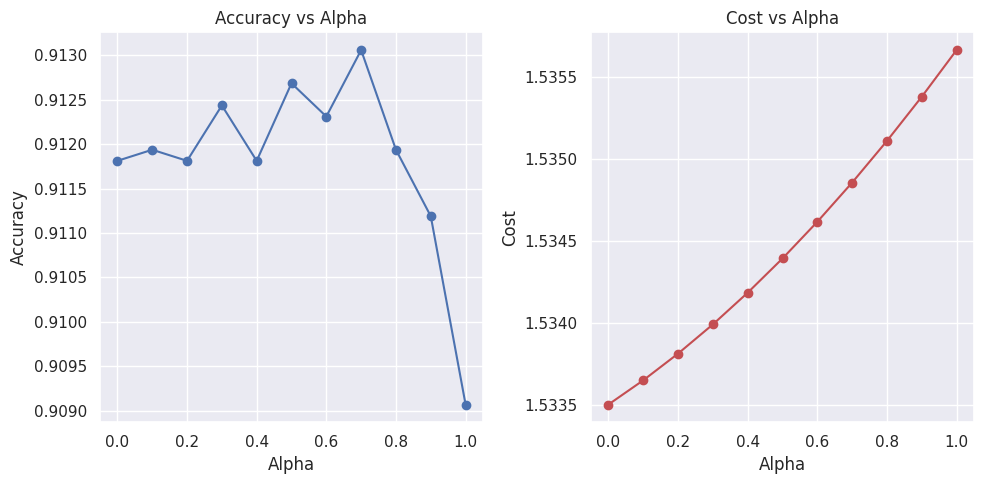

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ensemble_test_model_weighted(testloader, weights1, weights_last1, weights2, weights_last2, alpha=0.2):
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the weighted average ensemble model...")

    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Compute outputs for both models
        out1 = compute_out(weights1, weights_last1, x_test, y_test)
        out2 = compute_out(weights2, weights_last2, x_test, y_test)

        # Weighted average of the logits
        ensemble_out = (1- alpha) * out1 + ( alpha) * out2
        ensemble_pred = jnp.argmax(ensemble_out, axis=1)

        correct_predictions += jnp.sum(jnp.array(ensemble_pred == y_test).astype(int))
        total_samples += len(y_test)

        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(ensemble_out, y_test))
        total_cost += test_cost * len(y_test)

    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples
    print(f"Weighted Average Ensemble: Cost {avg_test_cost}, Acc {avg_test_acc}")

    # Return the results to use outside the function
    return avg_test_cost, avg_test_acc

# Define the range of alpha values to test
alpha_values = np.linspace(0, 1, 11)  # e.g., [0.0, 0.1, 0.2, ..., 1.0]
results = []

# Loop over each alpha value and store results
for alpha in alpha_values:
    avg_test_cost, avg_test_acc = ensemble_test_model_weighted(testloader, weights1, weights_last1, weights2, weights_last2, alpha)
    results.append({'Alpha': alpha, 'Average_Cost': avg_test_cost, 'Average_Accuracy': avg_test_acc})

# Create a DataFrame to store the results

results_df = pd.DataFrame(results)

# Display the table of results
print("Alpha = 0 = random Intialization")
print("Beta = 1 = Beta Intialization")
print(results_df)

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot accuracy vs alpha
plt.subplot(1, 2, 1)
plt.plot(results_df['Alpha'], results_df['Average_Accuracy'], marker='o', color='b')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')

# Plot cost vs alpha
plt.subplot(1, 2, 2)
plt.plot(results_df['Alpha'], results_df['Average_Cost'], marker='o', color='r')
plt.xlabel('Alpha')
plt.ylabel('Cost')
plt.title('Cost vs Alpha')

plt.tight_layout()
plt.show()

Testing the model confidence-based ensemble...
Confidence-Based Ensemble: Cost 1.533711566498699, Acc 0.9125608082823999
Final Confidence-Based Ensemble Results: Cost = 1.533711566498699, Accuracy = 0.9125608082823999
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5335028589107866, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533650361348049, Acc 0.9119371335911188
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533813119055647, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.533991121327637, Acc 0.9124360733441437
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5341843573313205, Acc 0.9118123986528627
Testing the weighted average ensemble model...
Weighted Average Ensemble: Cost 1.5343928161143405, Acc 0.9126855432206561
Testing the weighted average ensemble model...
Weight

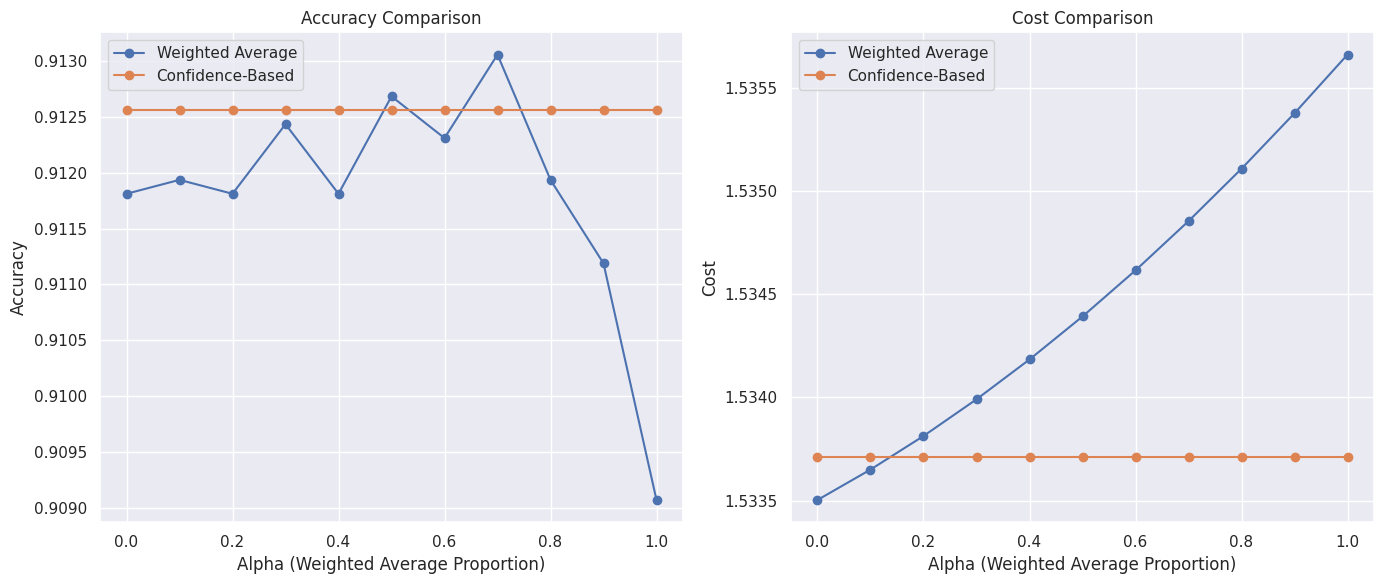

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import optax  # For loss calculations

# Define the function to compute ensemble predictions using model confidence
def ensemble_test_model_confidence(testloader, weights1, weights_last1, weights2, weights_last2):
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the model confidence-based ensemble...")

    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Compute outputs for both models
        out1 = compute_out(weights1, weights_last1, x_test, y_test)
        out2 = compute_out(weights2, weights_last2, x_test, y_test)

        # Calculate confidence (maximum softmax value) for each model
        conf1 = jnp.max(jnp.exp(out1) / jnp.sum(jnp.exp(out1), axis=1, keepdims=True), axis=1)
        conf2 = jnp.max(jnp.exp(out2) / jnp.sum(jnp.exp(out2), axis=1, keepdims=True), axis=1)

        # Normalize confidences to use as weights
        total_conf = conf1 + conf2
        weight1 = conf1 / total_conf
        weight2 = conf2 / total_conf

        # Weighted average of the logits based on confidence
        ensemble_out = (weight1[:, None] * out1) + (weight2[:, None] * out2)
        ensemble_pred = jnp.argmax(ensemble_out, axis=1)

        correct_predictions += jnp.sum(jnp.array(ensemble_pred == y_test).astype(int))
        total_samples += len(y_test)

        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(ensemble_out, y_test))
        total_cost += test_cost * len(y_test)

    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples
    print(f"Confidence-Based Ensemble: Cost {avg_test_cost}, Acc {avg_test_acc}")

    return avg_test_cost, avg_test_acc

# Test the ensemble method
test_cost, test_acc = ensemble_test_model_confidence(testloader, weights1, weights_last1, weights2, weights_last2)

# Display results
print(f"Final Confidence-Based Ensemble Results: Cost = {test_cost}, Accuracy = {test_acc}")

# Visualizations for comparison
# Generate data for visualization
alpha_values = np.linspace(0, 1, 11)  # For weighted average method
results_weighted = []

for alpha in alpha_values:
    avg_test_cost, avg_test_acc = ensemble_test_model_weighted(testloader, weights1, weights_last1, weights2, weights_last2, alpha)
    results_weighted.append({'Alpha': alpha, 'Average_Cost': avg_test_cost, 'Average_Accuracy': avg_test_acc})

results_weighted_df = pd.DataFrame(results_weighted)

# Combine results
methods = ['Weighted Average', 'Confidence-Based']
accuracy_results = [
    results_weighted_df['Average_Accuracy'].values,
    [test_acc] * len(alpha_values)  # Confidence-based accuracy (repeated for comparison)
]
cost_results = [
    results_weighted_df['Average_Cost'].values,
    [test_cost] * len(alpha_values)  # Confidence-based cost (repeated for comparison)
]

# Plot results
plt.figure(figsize=(14, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
for method, acc in zip(methods, accuracy_results):
    plt.plot(alpha_values, acc, marker='o', label=method)
plt.xlabel('Alpha (Weighted Average Proportion)')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Cost comparison
plt.subplot(1, 2, 2)
for method, cost in zip(methods, cost_results):
    plt.plot(alpha_values, cost, marker='o', label=method)
plt.xlabel('Alpha (Weighted Average Proportion)')
plt.ylabel('Cost')
plt.title('Cost Comparison')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import optax  # For loss calculations

# Define the Maximum Confidence Voting ensemble function
def ensemble_test_max_confidence(testloader, weights1, weights_last1, weights2, weights_last2):
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the Maximum Confidence Voting ensemble...")

    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Compute outputs for both models
        out1 = compute_out(weights1, weights_last1, x_test, y_test)
        out2 = compute_out(weights2, weights_last2, x_test, y_test)

        # Compute probabilities for both models using softmax
        prob1 = jnp.exp(out1) / jnp.sum(jnp.exp(out1), axis=1, keepdims=True)
        prob2 = jnp.exp(out2) / jnp.sum(jnp.exp(out2), axis=1, keepdims=True)

        # Select predictions based on maximum confidence
        max_conf = jnp.maximum(prob1, prob2)
        ensemble_pred = jnp.argmax(max_conf, axis=1)

        correct_predictions += jnp.sum(jnp.array(ensemble_pred == y_test).astype(int))
        total_samples += len(y_test)

        # Average cost calculation
        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(max_conf, y_test))
        total_cost += test_cost * len(y_test)

    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples
    print(f"Max Confidence Voting: Cost {avg_test_cost}, Acc {avg_test_acc}")

    return avg_test_cost, avg_test_acc

# Test the Maximum Confidence Voting method
max_conf_cost, max_conf_acc = ensemble_test_max_confidence(testloader, weights1, weights_last1, weights2, weights_last2)
print(f"Final Max Confidence Voting Results: Cost = {max_conf_cost}, Accuracy = {max_conf_acc}")


Testing the Maximum Confidence Voting ensemble...
Max Confidence Voting: Cost 1.9825166050720642, Acc 0.9126855432206561
Final Max Confidence Voting Results: Cost = 1.9825166050720642, Accuracy = 0.9126855432206561


In [ ]:
# Define the Product of Experts ensemble function
def ensemble_test_product_of_experts(testloader, weights1, weights_last1, weights2, weights_last2):
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the Product of Experts ensemble...")

    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Compute outputs for both models
        out1 = compute_out(weights1, weights_last1, x_test, y_test)
        out2 = compute_out(weights2, weights_last2, x_test, y_test)

        # Compute probabilities for both models using softmax
        prob1 = jnp.exp(out1) / jnp.sum(jnp.exp(out1), axis=1, keepdims=True)
        prob2 = jnp.exp(out2) / jnp.sum(jnp.exp(out2), axis=1, keepdims=True)

        # Combine probabilities using Product of Experts
        prod_prob = prob1 * prob2
        prod_prob /= jnp.sum(prod_prob, axis=1, keepdims=True)  # Normalize probabilities
        ensemble_pred = jnp.argmax(prod_prob, axis=1)

        correct_predictions += jnp.sum(jnp.array(ensemble_pred == y_test).astype(int))
        total_samples += len(y_test)

        # Average cost calculation
        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(prod_prob, y_test))
        total_cost += test_cost * len(y_test)

    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples
    print(f"Product of Experts: Cost {avg_test_cost}, Acc {avg_test_acc}")

    return avg_test_cost, avg_test_acc

# Test the Product of Experts method
prod_expert_cost, prod_expert_acc = ensemble_test_product_of_experts(testloader, weights1, weights_last1, weights2, weights_last2)
print(f"Final Product of Experts Results: Cost = {prod_expert_cost}, Accuracy = {prod_expert_acc}")


Testing the Product of Experts ensemble...
Product of Experts: Cost 1.8513862669389465, Acc 0.9126855432206561
Final Product of Experts Results: Cost = 1.8513862669389465, Accuracy = 0.9126855432206561


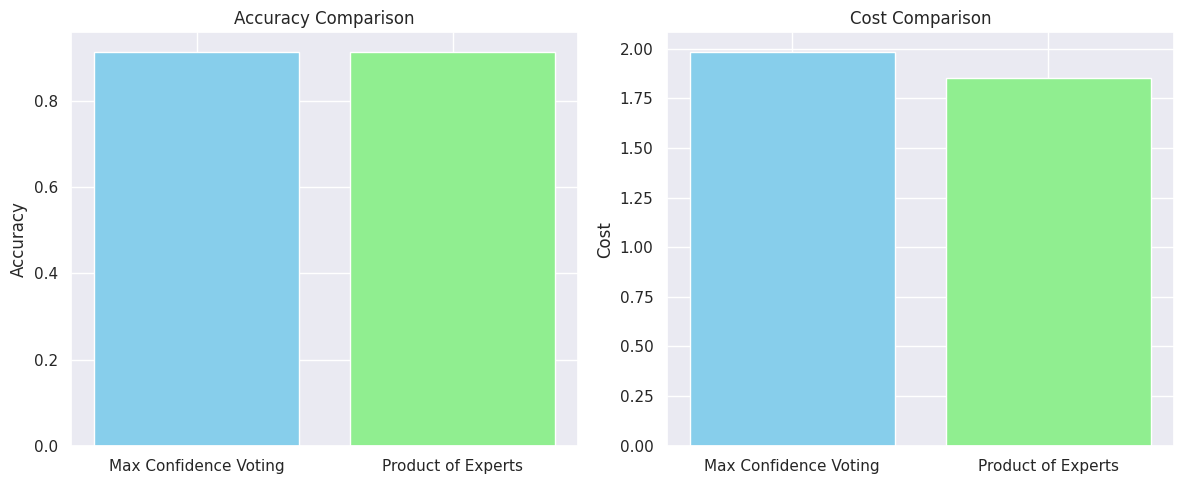

In [ ]:
# Visualization
methods = ['Max Confidence Voting', 'Product of Experts']
accuracy_results = [max_conf_acc, prod_expert_acc]
cost_results = [max_conf_cost, prod_expert_cost]

plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(methods, accuracy_results, color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

# Cost comparison
plt.subplot(1, 2, 2)
plt.bar(methods, cost_results, color=['skyblue', 'lightgreen'])
plt.ylabel('Cost')
plt.title('Cost Comparison')

plt.tight_layout()
plt.show()
